In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
% matplotlib inline

In [3]:
### function to generate fake data for a line
def fake_line(N,m,b):
    x = np.sort(10*np.random.rand(N))
    y = m*x+b
    yerr = 2.+1.*np.random.rand(N) # error bars sampled from Normal(2,1)
    y += yerr * np.random.randn(N)
    return x, y, yerr

In [4]:
### probabilites here
def lnlike(theta, x, y, yerr):
    m, b = theta[0], theta[1]
    model = m * x + b
    return -0.5*(np.sum((y-model)**2/yerr**2 - np.log(1.0/yerr**2)))

def lnprior(theta):
    m, b = theta[0], theta[1]
    if -10.0 < m < 10.0 and -10.0 < b < 10.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [39]:
### M-H MCMC sampler from Problem2 -- with some modifications to make it applicable here
def MHsampler(lnprob, args, propw, start, steps):
    '''
    Arguments:
    lnprob: log of probability density to be sampled
    args: arguments for lnprob
    prop: "width" of proposal density
    start: starting point of chain
    steps: number of steps of chain
    '''
    x, y, yerr = args
    ndim = len(start)
    chain = np.empty((ndim,steps)) # to store samples
    chain[:,0] = np.asarray(start) # starting point
    prop = np.empty(ndim)
    for i in np.arange(steps-1):
        # draw your next step -- use Uniform distribution as proposal density
        prop[0] = np.random.uniform(chain[:,i][0]-propw,chain[:,i][0]+propw)
        prop[1] = np.random.uniform(chain[:,i][1]-propw,chain[:,i][1]+propw)
        # acceptance ratio
        lnalpha = lnprob(prop,x,y,yerr)-lnprob(chain[:,i],x,y,yerr)
        # decision time!
        if np.isinf(lnalpha):
            chain[:,i+1] = chain[:,i]
        elif lnalpha >= 0 or np.isnan(lnalpha):
            chain[:,i+1] = prop
        else:
            r = np.random.uniform(0,1)
            while not np.isfinite(r):
                r = np.random.uniform(0,1)
            if lnalpha >= np.log(r):
                chain[:,i+1] = prop
            elif lnalpha < np.log(r):
                chain[:,i+1] = chain[:,i]
    return chain

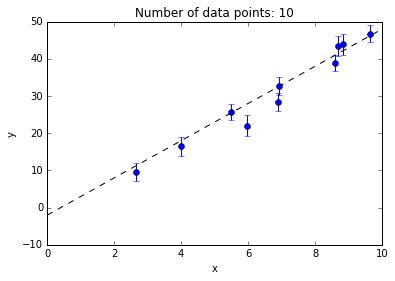

With homemade MH-MCMC sampler
Acceptance fraction is 0.34.


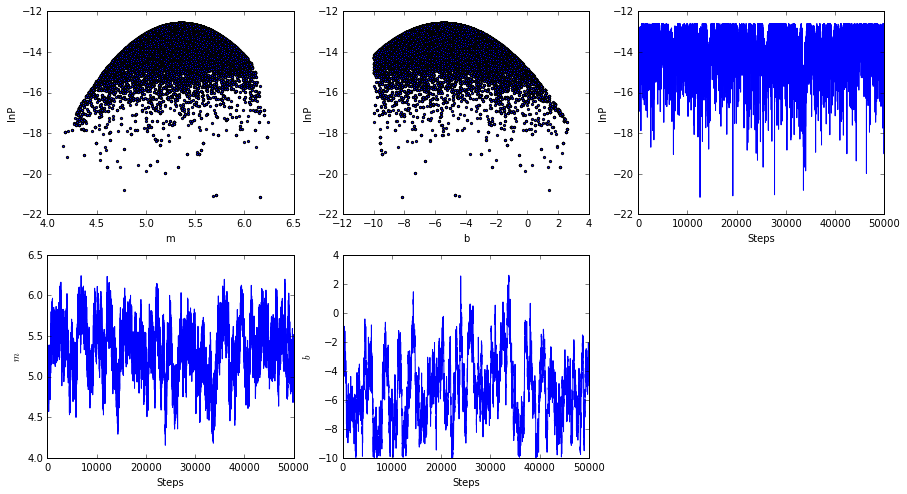

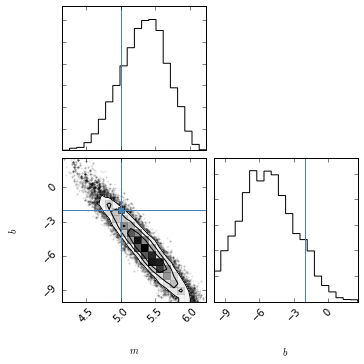

Using emcee


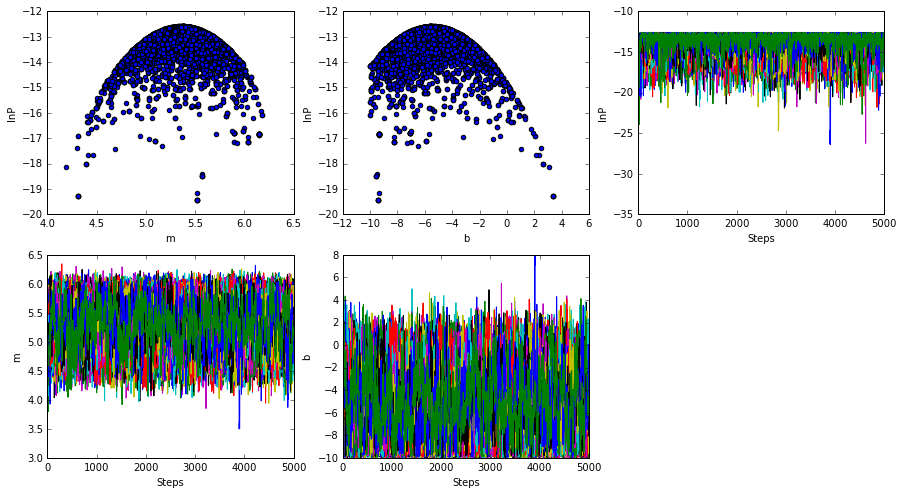

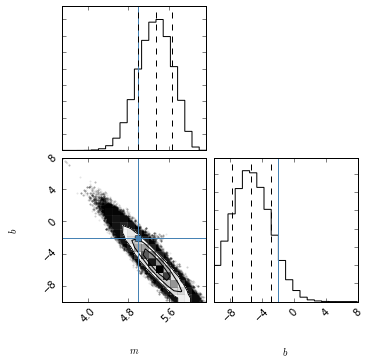

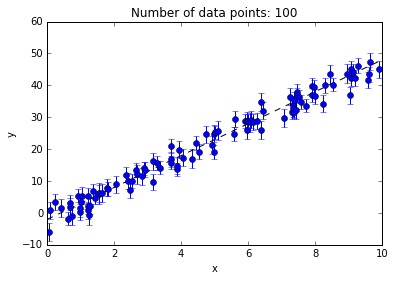

With homemade MH-MCMC sampler
Acceptance fraction is 0.34.


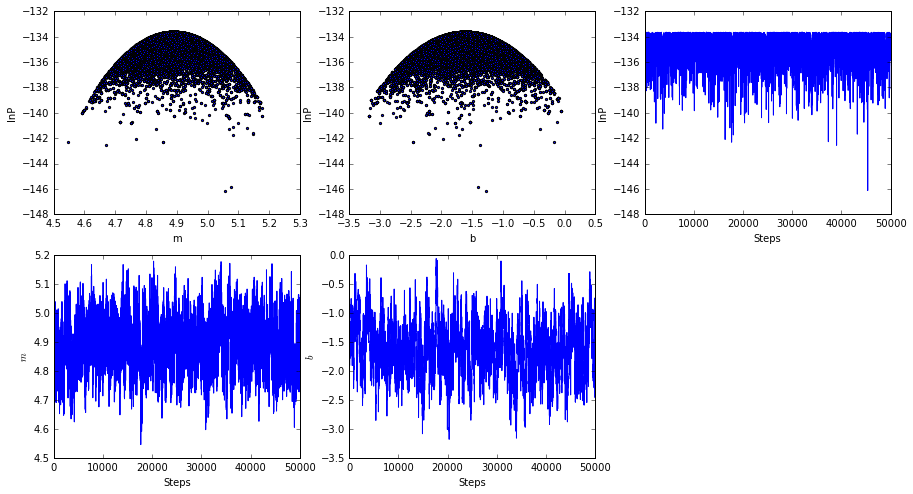

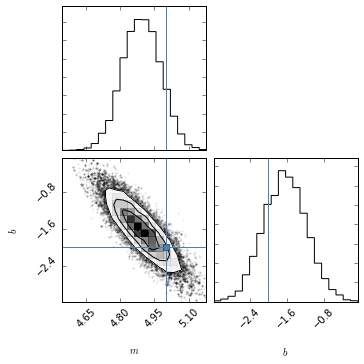

Using emcee


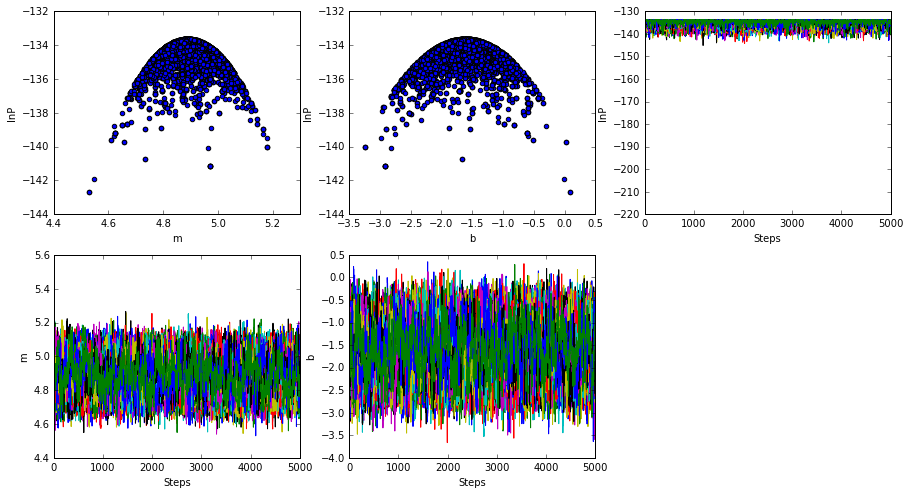

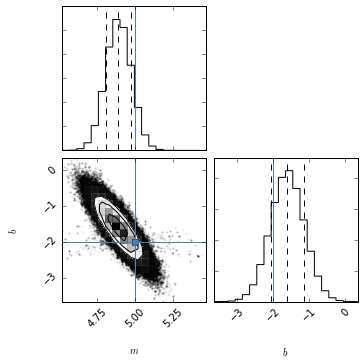

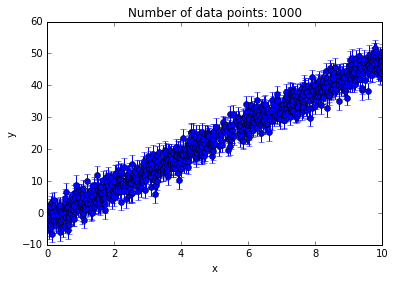

With homemade MH-MCMC sampler
Acceptance fraction is 0.41.


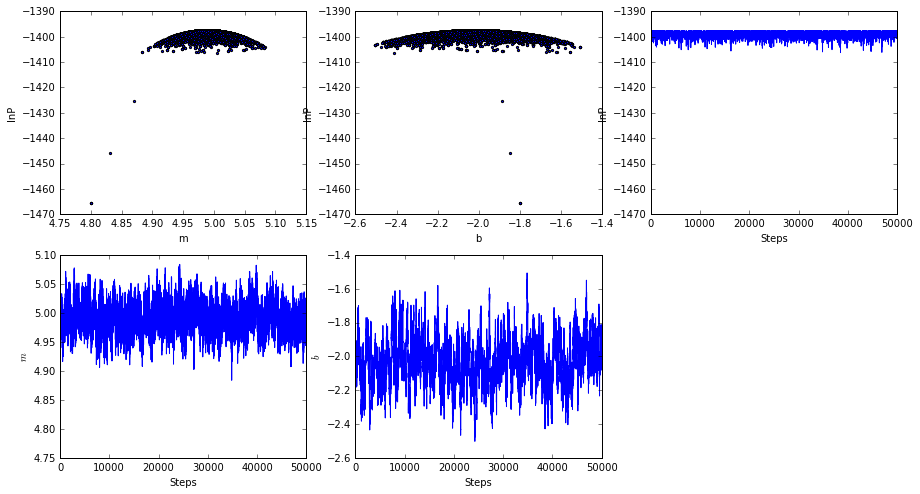

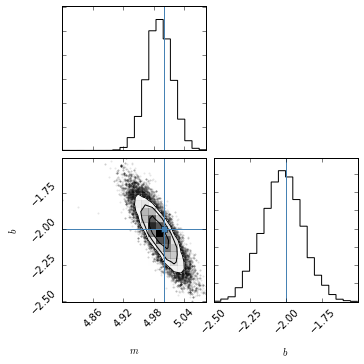

Using emcee


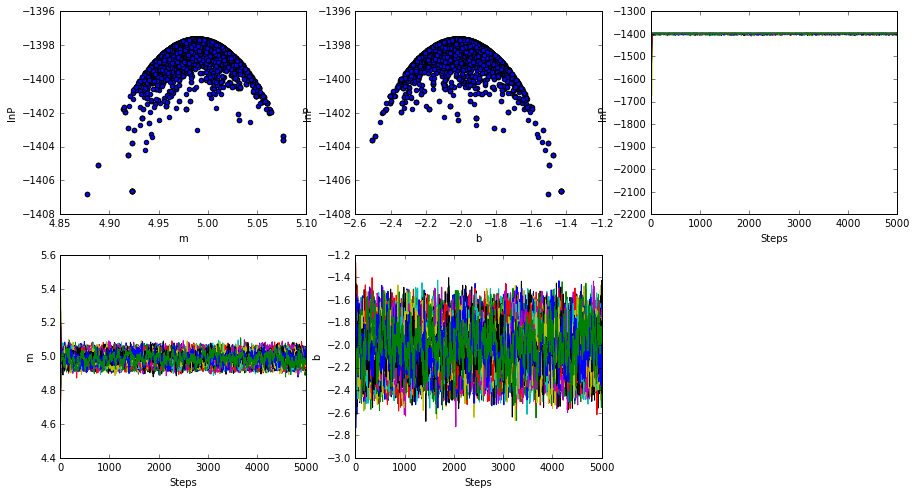

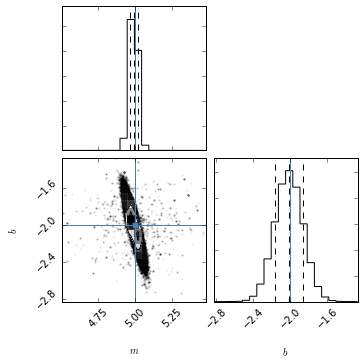

In [45]:
### true parameters
m_t = 5
b_t = -2

for N, propw in [(10,0.5), (100,0.2), (1000,0.05)]:
    # proposal density widths were fiddled with by hand to get good acceptance ratio
    # generate some fake data
    x, y, yerr = fake_line(N,m_t,b_t)
    x_t = np.linspace(0,10,200)
    y_t = m_t*x_t + b_t

    # plot 
    plt.plot(x_t, y_t, c='k', ls='--')
    plt.errorbar(x,y,yerr=yerr,fmt='o')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Number of data points: {}'.format(N))
    plt.show()

    ### time to run the sampler
    print "With homemade MH-MCMC sampler"
    args = (x,y,yerr)
    start = (4.8,-1.8)
    steps = 50000
    samples = MHsampler(lnprob, args, propw = propw, start=start, steps=steps)

    # check acceptance fraction is reasonable
    acc_frac = float(np.unique(samples).size/2)/steps
    print "Acceptance fraction is {:.2f}.".format(acc_frac)

    # convergence plots
    ms = samples[0,:]
    bs = samples[1,:]
    lnprobs = [lnprob(samples[:,i],x,y,yerr) for i in xrange(steps)]

    fig2, axarr = plt.subplots(2,3, figsize=(3*5,2*4))
    axarr[0,0].scatter(ms, lnprobs ,marker='.')
    axarr[0,0].set_xlabel(r'm')
    axarr[0,0].set_ylabel(r'lnP')

    axarr[0,1].scatter(bs, lnprobs ,marker='.')
    axarr[0,1].set_xlabel(r'b')
    axarr[0,1].set_ylabel(r'lnP')

    axarr[0,2].plot(np.arange(steps),lnprobs)
    axarr[0,2].set_xlabel(r'Steps')
    axarr[0,2].set_ylabel(r'lnP')

    axarr[1,0].plot(np.arange(steps),ms)
    axarr[1,0].set_xlabel(r'Steps')
    axarr[1,0].set_ylabel(r'$m$')

    axarr[1,1].plot(np.arange(steps),bs)
    axarr[1,1].set_xlabel(r'Steps')
    axarr[1,1].set_ylabel(r'$b$')
    
    axarr[1,2].set_axis_off()
    plt.show(fig2)

    # corner plot here
    samples2 = samples.T
    fig3 = corner.corner(samples2, labels=["$m$", "$b$"], truths=[m, b])
    plt.show(fig3)

    ### now use emcee
    print "Using emcee"
    ndim, nwalkers = 2, 100
    pos = [np.array([np.random.uniform(4.5,5.5),np.random.uniform(-2.5,-1.5)]) for i in range(nwalkers)]
    emcee_sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x,y,yerr))
    emcee_sampler.run_mcmc(pos, 5000)

    # convergence plots
    fig4, axarr2 = plt.subplots(2,3,figsize=(3*5,2*4))
    
    [axarr2[0,0].scatter(emcee_sampler.chain[i,:,0], emcee_sampler.lnprobability[i,:]) for i in range(1)]
    axarr2[0,0].set_xlabel('m')
    axarr2[0,0].set_ylabel('lnP');
    
    [axarr2[0,1].scatter(emcee_sampler.chain[i,:,1], emcee_sampler.lnprobability[i,:]) for i in range(1)]
    axarr2[0,1].set_xlabel('b')
    axarr2[0,1].set_ylabel('lnP');
                                
    [axarr2[0,2].plot(emcee_sampler.lnprobability[i,:]) for i in range(100)]
    axarr2[0,2].set_xlabel('Steps')
    axarr2[0,2].set_ylabel('lnP');

    [axarr2[1,0].plot(emcee_sampler.chain[i,:,0]) for i in range(100)]
    axarr2[1,0].set_xlabel('Steps')
    axarr2[1,0].set_ylabel('m');

    [axarr2[1,1].plot(emcee_sampler.chain[i,:,1]) for i in range(100)]
    axarr2[1,1].set_xlabel('Steps')
    axarr2[1,1].set_ylabel('b');
    
    axarr2[1,2].set_axis_off()
    plt.show(fig4)

    # corner plot
    emcee_samples = emcee_sampler.chain[:,:, :].reshape((-1, ndim))
    fig5 = corner.corner(emcee_samples, labels=["$m$", "$b$"], quantiles=[0.16, 0.5, 0.84], truths=[m, b])
    plt.show(fig5)